# D5 : Modèle de Hopfield
---

Dans le dernier cours et le TD associé, nous avons étudié le modèle de Hopfield : C'est un modèle simplifié pour expliquer comment des motifs (mémoires) peuvent être stockés dans les connexions synaptiques et être récupérés par la dynamique du réseau. C'est l'archétype d'un réseau attracteur, dont le mécanisme sousjacent a par la suite également été démontré fonctionner avec des modèles de réseau plus compliqué (réseau à spike, modèles de taux de décharge etc.). 

Dans ce devoir, nous allons continuer à nous familiariser avec le modèle de Hopfield. Veuillez vous référer aux diapos du cours et les équations dans le notebook du TD associé pour la définition précise du modèle.


In [1]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Récupération d'un motif, $K=1$

Dans le TD, nous avons simulé l'évolution d'un réseau dont les poids synaptiques étaient choisis pour encoder un smiley. Pour une valeur de $\beta$ suffisamment grande (approx. $\beta>3$ dans le cas étudié), le réseau évolue dans le sens souhaité, c'est-à-dire réproduit petit à petit le motif stocké. 

Reproduisez ici, pour $\beta=5$, l'évolution du réseau pour un autre motif : au lieu d'importer le fichier `smiley.dat`, nous utiliserons `flowers.dat`. Choissisez un overlap initial de 800 pixels, et itérer 10 fois (`nt = 11`). Plottez l'état du réseau à chaque étape à commencer avec l'état initial.

In [2]:
# define some useful functions you can use below
# ----------------------------------------------

# gain function
def g(h, beta=1.):
    """Gain function: probability of a neuron to be 
    in the active state given the input h, for a 
    given value of beta (default value 1)."""
    return 1/(1+np.exp(-beta*h))


# overlap between a given pattern and a state
def overlap(state, pattern):
    return sum(state*pattern)/N


# a plot function to easily plot the 
# network state as an image
def plot_state(state):
    plt.imshow(state.reshape((nx,ny)), cmap='Greys_r')
    plt.pause(1)

In [3]:
# import an image that we will use as first motif
img = np.loadtxt('flowers.dat')
nx, ny = img.shape

# create our Hopfield net
# -----------------------

# convert the 2D pixel matrix to a 1D pattern vector
P0 = img.flatten()

# the network size is given by the length of the pattern
N = len(P0)

# for a single pattern, the weight matrix is given by
W = P0[:,None] * P0[None,:] / N

# enforce empty diagonal (no self-connections)
W[np.arange(N),np.arange(N)] = 0

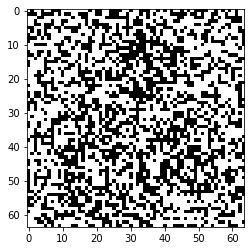

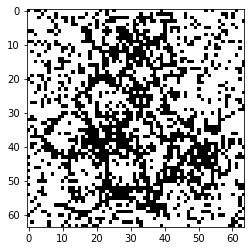

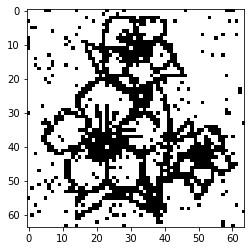

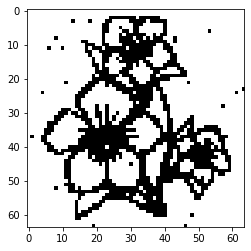

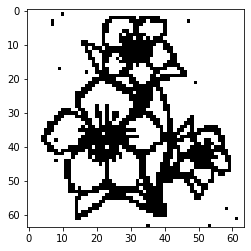

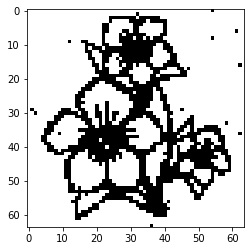

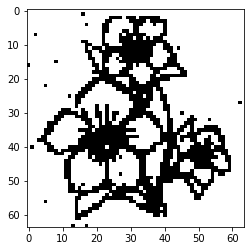

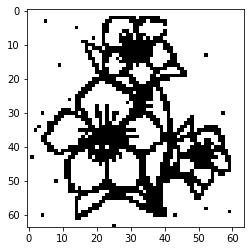

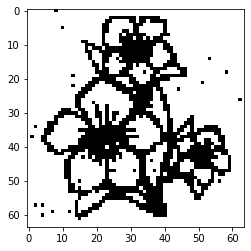

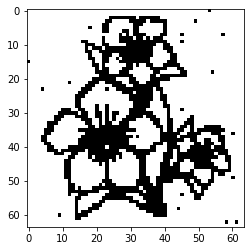

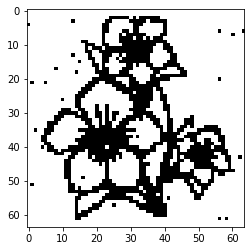

In [4]:
# Dynamique du réseau de Hopfield
# -------------------------------

nt = 11

# matrice représentant les états successifs 
# du réseau
S = np.zeros((nt,N))

# 1) Définissez l'état initial : 
# 1.a - initialization aléatoire
# 1.b - overap partiel de 1000 pixels

S[0] = 2*np.round(np.random.uniform(size=N))-1 # clear previous initial condition
nover = 1000
inds_over = np.random.choice(N, size=nover, replace=False)
S[0,inds_over] = P0[inds_over] 

plot_state(S[0])

# 2) Itération

for i in range(nt-1):
    # déterminer les h_i
    h = W.dot(S[i])
    
    # calculer la probabilité 
    p = g(h, beta=5)
    
    # tirage alétoir du nouvel état t+1
    is_up = np.random.uniform(size=N) < p
    S[i+1] = 2*is_up - 1
    
    plot_state(S[i+1])


#### Variation de la dynamique avec $\beta$

Répetez la dynamique pour différentes valeurs de $\beta$, `betas = np.array([1, 2, 5, 10, 20])`, et calculez chaque fois l'overlap $m$ avec le motif. Plottez $m(t)$ en fonction de $t$ pour les différentes valeurs de $\beta$. 

*Astuce :* Utilisez la fonction `overlap` définie plus haut pour calculer $m$.

In [5]:
betas = np.array([1, 2, 3, 4, 5, 10, 20])
nb = len(betas)

# créer matrice pour les valeurs d'overlap
m = np.zeros((nt,nb))

# overlap initial le même pour tous les betas
m[0] = overlap(S[0], P0)

# boucle sur tous les betas
for j, beta in enumerate(betas):
    for i in range(nt-1):
        # déterminer les h_i
        h = W.dot(S[i])

        # calculer la probabilité 
        p = g(h, beta=beta)

        # tirage alétoir du nouvel état t+1
        is_up = np.random.uniform(size=N) < p
        S[i+1] = 2*is_up - 1

        m[i+1,j] = overlap(S[i+1],P0)

Text(0, 0.5, 'overlap')

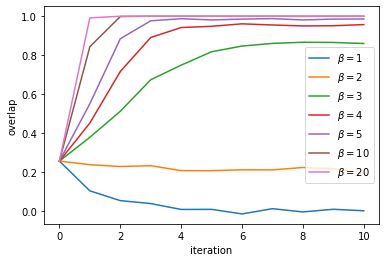

In [6]:
# Plotter l'overlap pour différents beta
fig, ax = plt.subplots()
ax.plot(m)
ax.legend(labels=[r'$\beta=%g$'%b for b in betas])
ax.set_xlabel('iteration')
ax.set_ylabel('overlap')

**Remarque 1 (reprise du TD) :** On peut calculer l'overlap moyen finale $m^*$ que $m$ va approcher par le bas ou par le haut, si l'on suppose que cet overlap est donné (en moyenne) par 
$$m^*=\frac{1}{N}\sum_i [ prob(S_i=1) P_i + prob(S_i-1) P_i]$$ 
où $prob(S_i=1) = g(P_i m^*)$. On trouve alors une équation que doit obéir $m^*$,
$$m^*=\tanh(\frac{\beta m^*}{2}),$$
qu'il faut résoudre numériquement pour déterminer la valeur de $m^*$.

**Remarque 2 :** Il en suit par ailleurs une condition pour $\beta$ pour qu'un état stationnaire avec overlap non-nul $m^*>0$ puisse exister. Pour $m^*=0$, les deux côtés de l'équation ci-dessus sont 0, puisque $\tanh(0)=0$. Pour $m=1$ (valeur maximale de l'overlap possible), $1 > \tanh(\beta/2)$. Donc pour qu'il puisse exister un $m^*>0$ satisfaisant l'équation $m^*=\tanh({\beta m^*}/{2})$, il faut que pour des plus petits overlaps $0<m<m^*$, $m<\tanh(\beta m/2)$. (S'il y a changement de signe de $m-\tanh({\beta m}/{2})$ entre $m<m^*$ et $1>m^*$, il doit exister un $m^*$ pour lequel $m^*-\tanh({\beta m^*}/{2})=0$. Un petit $m>0$ avec $m<\tanh(\beta m/2)$ peut exister seulement si $\tanh(\beta m/2)$ augmente plus rapidement que $m$ en partant de 0. Exprimé en termes de la dérivée à 0, cela revient à constater qu'il faut que $\frac{d}{dm}\tanh(\beta m/2)|_{m=0} = \beta/2 >0$, ou $\beta>2$. Comme nous l'avions vu dans nos simulations, le réseau ne peut pas récupérer le motif si $\beta<=2$ ! 


In [7]:
# Nous pouvons comparer avec le résultat théorique rapporté 
# dans le notebook complété du TD 

# importer une routine qui permet de trouver
# le zéro d'une fonction 
from scipy.optimize import brentq

# l'expression qui devient 0 pour la bonne 
# valeur de m
def target(m, beta):
    return m - np.tanh(beta*m/2)

x = np.linspace(1,0,1001)
mstar = np.zeros(nb)


# limite supérieure
m_sup = 1.

for i, b in enumerate(betas):
    # considérer qu'une solution avec m*>0 
    # existe seulement pour beta > 2
    # (pourquoi ? pour qu'une solution non-
    # triviale existe, 'target' doit dévenir
    # négatif avant de franchir le zéro 
    # --> la dérivée à m=0 doit être négatif !)
    if b>2:
        # limite inférieure : prendre la première 
        # valeur pour laquelle notre fonction 
        # 'target' change de signe
        m_inf = next(v for v in x if target(v,b)<0)

        # utiliser la routine pour déterminer 
        # le zéro précis
        mstar[i] = brentq(target, m_inf, m_sup, args=(b,))


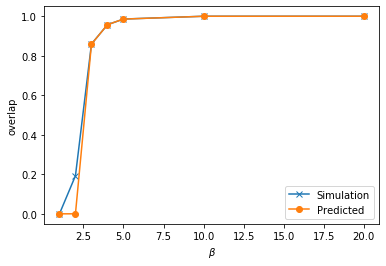

In [8]:
fig, ax = plt.subplots()
ax.plot(betas, m[-1], '-x', label='Simulation')
ax.plot(betas, mstar, '-o', label='Predicted')
ax.set_xlabel(r'$\beta$')
ax.set_ylabel('overlap')
ax.legend()

### 2. Récupération d'un motif, $K=2$

Dans le cours, nous avons vu que la capacité maximale d'un réseau de Hopfield est $K_c=0.138 N$, ce qui dans notre cas ($N=4096$) suggère que le réseau peut stocker jusqu'à 565 motifs différents. On va faire plus simple et n'en considérer que deux. 

Construisez un réseau de Hopfield avec des connexions synaptiques pour stocker les deux motifs `smiley.dat` et `flowers.dat`. Pour cela, créez / définissez d'abord deux arrays P0 et P1 correspondant à chaque motif respectif. Rappelez-vous que la matrice de connectivité et ensuite donnée par l'addition des matrices de connectivité qu'on obtiendrait pour chaque motif individuellement.

In [9]:
# For simplicity, here are the two patterns:
P0 = np.loadtxt('smiley.dat').flatten()
P1 = np.loadtxt('flowers.dat').flatten()

# La matrice de connectivité est donnée par 
# la somme des deux motifs :
W = P0[:,None]*P0[None,:]/N + P1[:,None]*P1[None,:]/N 
W[np.arange(N),np.arange(N)] = 0


Maintenant que vous avex créé le réseau, simulez l'évolution pour des conditions initiales différentes, avec un overlap initial différent avec les deux motifs (voir ci-dessous). Pour chaque condition, calculez l'overlap avec chacun des deux motifs, et plottez comment les overlaps avec les deux motifs évoluent avec le temps (i.e., plottez $m^0(t)$ et $m^1(t)$ sur le même graphe).

Dans le code suivant, je suppose que la variable `S` représente toujours l'état du reseau aux différents moments et est une matrice avec la forme `(nt,N)`.

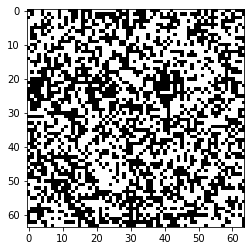

In [10]:
# 1) Initial overlap with first pattern only
S[0] = 2*np.round(np.random.uniform(size=N))-1 # clear previous initial condition
nover = 800
inds_over = np.random.choice(N, size=nover, replace=False)
S[0,inds_over] = P0[inds_over] 

plot_state(S[0])

In [11]:
# overlap
m = np.zeros((nt,2))

# overlap initial 
m[0] = [overlap(S[0],P) for P in [P0,P1]]

for i in range(nt-1):
    # déterminer les h_i
    h = W.dot(S[i])

    # calculer la probabilité 
    p = g(h, beta=5)

    # tirage alétoir du nouvel état t+1
    is_up = np.random.uniform(size=N) < p
    S[i+1] = 2*is_up - 1

    m[i+1] = [overlap(S[i+1],P) for P in [P0,P1]]


Text(0, 0.5, 'overlap')

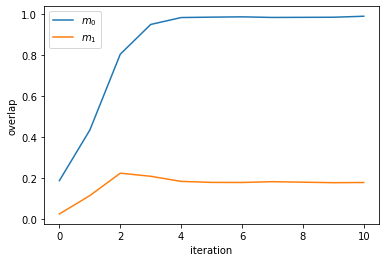

In [12]:
# Plotter l'overlap pour différents beta
fig, ax = plt.subplots()
ax.plot(m)
ax.legend(labels=[r'$m_%g$'%i for i in range(2)])
ax.set_xlabel('iteration')
ax.set_ylabel('overlap')

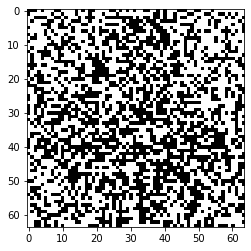

In [13]:
# 2) Initial overlap with second pattern only
S[0] = 2*np.round(np.random.uniform(size=N))-1 # clear previous initial condition
nover = 800
inds_over = np.random.choice(N, size=nover, replace=False)
S[0,inds_over] = P1[inds_over] 

plot_state(S[0])

In [14]:
# overlap
m = np.zeros((nt,2))

# overlap initial 
m[0] = [overlap(S[0],P) for P in [P0,P1]]

for i in range(nt-1):
    # déterminer les h_i
    h = W.dot(S[i])

    # calculer la probabilité 
    p = g(h, beta=5)

    # tirage alétoir du nouvel état t+1
    is_up = np.random.uniform(size=N) < p
    S[i+1] = 2*is_up - 1

    m[i+1] = [overlap(S[i+1],P) for P in [P0,P1]]


Text(0, 0.5, 'overlap')

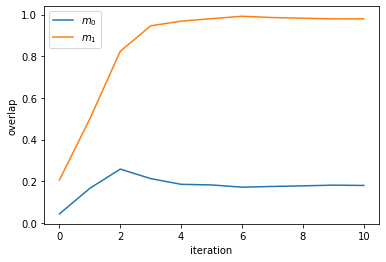

In [15]:
# Plotter l'overlap pour différents beta
fig, ax = plt.subplots()
ax.plot(m)
ax.legend(labels=[r'$m_%g$'%i for i in range(2)])
ax.set_xlabel('iteration')
ax.set_ylabel('overlap')

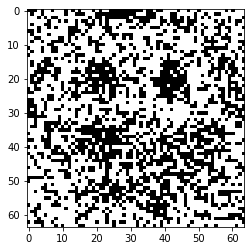

In [16]:
# 3) Initial overlap with both patterns
S[0] = 2*np.round(np.random.uniform(size=N))-1 # clear previous initial condition
nover0 = 400
nover1 = 400
inds_over0 = np.random.choice(N//2, size=nover, replace=False)
inds_over1 = N//2 + np.random.choice(N//2, size=nover, replace=False)
S[0,inds_over0] = P0[inds_over0] # partial overlap (first 800 neurons)
S[0,inds_over1] = P1[inds_over1] # partial overlap (first 800 neurons)



plot_state(S[0])


In [17]:
# overlap
m = np.zeros((nt,2))

# overlap initial 
m[0] = [overlap(S[0],P) for P in [P0,P1]]

for i in range(nt-1):
    # déterminer les h_i
    h = W.dot(S[i])

    # calculer la probabilité 
    p = g(h, beta=5)

    # tirage alétoir du nouvel état t+1
    is_up = np.random.uniform(size=N) < p
    S[i+1] = 2*is_up - 1

    m[i+1] = [overlap(S[i+1],P) for P in [P0,P1]]


Text(0, 0.5, 'overlap')

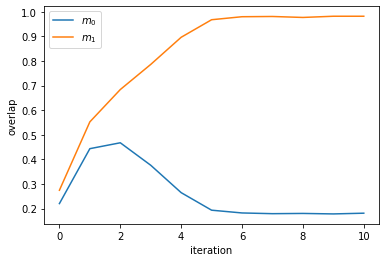

In [18]:
# Plotter l'overlap pour différents beta
fig, ax = plt.subplots()
ax.plot(m)
ax.legend(labels=[r'$m_%g$'%i for i in range(2)])
ax.set_xlabel('iteration')
ax.set_ylabel('overlap')

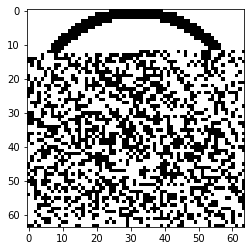

In [19]:
# 4) Initial overlap with both patterns (stealth mode)
S[0] = 2*np.round(np.random.uniform(size=N))-1 # clear previous initial condition
nover0 = 800
nover1 = 1000
inds_over1 = nover0 + np.random.choice(N-nover0, size=nover, replace=False)
S[0,:nover0] = P0[:nover0] # partial overlap (first 800 neurons)
S[0,inds_over1] = P1[inds_over1] # partial overlap (first 800 neurons)


plot_state(S[0])


In [20]:
# overlap
m = np.zeros((nt,2))

# overlap initial 
m[0] = [overlap(S[0],P) for P in [P0,P1]]

for i in range(nt-1):
    # déterminer les h_i
    h = W.dot(S[i])

    # calculer la probabilité 
    p = g(h, beta=5)

    # tirage alétoir du nouvel état t+1
    is_up = np.random.uniform(size=N) < p
    S[i+1] = 2*is_up - 1

    m[i+1] = [overlap(S[i+1],P) for P in [P0,P1]]


Text(0, 0.5, 'overlap')

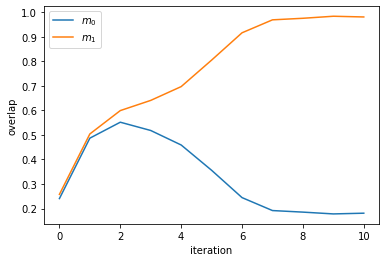

In [21]:
# Plotter l'overlap pour différents beta
fig, ax = plt.subplots()
ax.plot(m)
ax.legend(labels=[r'$m_%g$'%i for i in range(2)])
ax.set_xlabel('iteration')
ax.set_ylabel('overlap')

Pour la condition (3), est-ce que vous observez toujours le même résultat si vous répetez l'itération ? 
   - Non, le résultat dépend de l'état initial précis et/ou de petites fluctuations dans l'overlap avec les deux motifs, fluctuations qui finiront par être amplifiées tel qu'un seul motif gagne.

Pour la condition (4), est-ce que le résultat vous a surpris ? Pourquoi ?
   - L'overlap initial avec le deuxième motif  étant plus grand, il n'est pas surprénant qu'il est celui qui sera finalement récupéré.  

## 3. BONUS : La capacité du réseau d'Hopfield

Dans le TD nous avons commencé à regarder l'influence de la présence des autres motifs $\mu\neq\nu$ pour la dynamique de récupération d'un motif particulier $\nu$. Puisque les $P^\mu_i$ sont -1 ou 1 avec probabilité 0.5 a priori, j'ai argumenté que cette présence des autres motifs revient à un bruit dans la matrice de connextion $w_{ij}$ (toujours pour $i\neq j$) selon
$$w_{ij} = w^0_{ij}  + \xi_{ij},$$
où $w^0_{ij} = \frac{1}{N} P^0_i P^0_j$ est la matrice de connectivité pour le seul motif $\nu=0$, et les nombres aléatoires $\xi_{ij}$ sont issus d'une distribution Gaussienne avec moyenne $\langle\xi_{ij}\rangle = 0$  et variance $\langle\xi_{ij}^2\rangle = (K-1)/N^2$.

Implémentez un réseau de Hopfield avec un motif précis donné (`smiley.dat` ou `flowers.dat`) et du bruit correspondant à la présence de $K-1$ d'autres motifs. Itérez le réseau pour différentes valeurs de $K$, `Ks = [100, 200, 500, 1000, 2000]`. Qu'est-ce que vous observez si vous plottez l'overlap avec le motif donné en fonction du temps pour les différents $K$ ? Commencez à nouveau avec un overlap initial de 800 pixels.

**Rappel :** Des nombres aléatoires suivant une distribution normale peuvent être obtenus avec `np.random.normal(...)`.

**Attention :** Veillez à ce que $\xi_{ij}=\xi_{ji}$ ! Une possibilité de symmétriser les $\xi_{ij}$ sera de rajouter la transposé à la matrice d'origine : `xi_symm = (xi + xi.T)/np.sqrt(2)`, où je suppose que `xi` est une matrice de nombres aléatoires avec dimension $N\times N$ et la variance souhaitée (pour que la variance de `xi_symm` ne soit pas plus grande, il faut diviser par $\sqrt{2}$).

**Astuce :** Eviter d'afficher l'état du réseau à chaque itération, ou changez la durée de (voir enlevez) la pause imposé dans la définition de `plot_state`.

In [22]:
# La matrice de connectivité correspondant
# au motif considéré
W0 = P0[:,None]*P0[None,:]/N 
W0[np.arange(N),np.arange(N)] = 0

# Nombre de motifs contribuant "du bruit"
Ks = [100, 200, 500, 1000, 2000]
nK = len(Ks)


# État initial avec overlap intial de 800 pixels 
S[0] = 2*np.round(np.random.uniform(size=N))-1 # clear previous initial condition
nover = 800
inds_over = np.random.choice(N, size=nover, replace=False)
S[0,inds_over] = P0[inds_over] 

# overlap
m = np.zeros((nt,nK))
m[0] = overlap(S[0],P0)

# boucle sur les K
for j, K in enumerate(Ks):
    
    # tirage des nombres aléatoires
    # représentant le bruit induit 
    # par la présence de K-1 d'autres motifs
    
    xi = np.random.normal(loc=0,scale=np.sqrt(K-1)/N,size=(N,N))
    xi_symm = (xi + xi.T)/np.sqrt(2)
    xi_symm[np.arange(N),np.arange(N)] = 0
    
    W = W0 + xi_symm
    
    for i in range(nt-1):
        # déterminer les h_i
        h = W.dot(S[i])

        # calculer la probabilité 
        p = g(h, beta=5)

        # tirage alétoir du nouvel état t+1
        is_up = np.random.uniform(size=N) < p
        S[i+1] = 2*is_up - 1

        m[i+1,j] = overlap(S[i+1],P0) 


Text(0, 0.5, 'overlap')

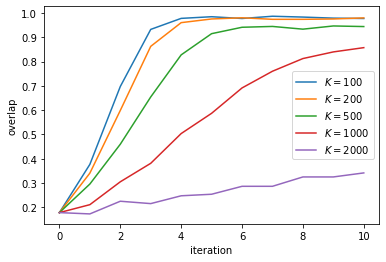

In [23]:
# Plotter l'overlap pour différents beta
fig, ax = plt.subplots()
ax.plot(m)
ax.legend(labels=[r'$K = %g$'%K for K in Ks])
ax.set_xlabel('iteration')
ax.set_ylabel('overlap')

Qu'est-ce que vous observez ? Est-ce que cela vous permet de conclure quelque chose sur la capacité du réseau ?

  - Pour $K$ sensiblement plus grand que $K_{\rm max}$, le réseau est en effet incapable de reproduire le motif souhaité. 
  - La dégradation semble être graduelle avec l'approche/le franchissement de $K_{\rm max}$.